# Notebook 04: Volatile Product Recovery

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

This notebook simulates the fermentation of acetogenic growth in a large scale bubble column reactor at two given temperatures, using mass balances as defined in notebook 01, and a thermodynaminc-based black box model of acetogenic growth, building on notebook 02.

Notebook author: Philip J. Gorter de Vries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

## Bubble column setup:

In [2]:
R = 8.314
TR, PR = 272.95, 9290 #http://www.ddbst.com/en/EED/PCP/VAP_C4.php

#Temperature range:
T0 = 273.15
dt = 80

T = np.arange(T0, T0+dt+1, 1)

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

#Reactor
F_L = 1 * 10**-3 #Fluid inflow rate with C-source supplement [m^3]
F_G = 1 * 10**4 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r = 3 # radius of the reactor [m]
h = 30 # height of the reactor [m]

#deduceable parameters
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v_gas = F_G/A/3600 #average gas velocity [m/s]
Gas_holdup = 0.6 * (v_gas)**0.7 #from Stephanie's paper
V_G = V_L * Gas_holdup
c_H2O = 10**6/18 #[mM] concentration of water (in pure water) for mol fraction calculation

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

# Define vapor pressure as functions of temperature

<p> Antoine equation: </p>
<div style="text-align: center">  $ log_{10}(P_T/P_0) = A_1 - A_2/(T + A_3) $
    <span style="float:right;">(eq. 12)</span>
</div>
<br>
<div style="text-align: center">  $ P(T) = 10^{A_1 - A_2/(T + A_3)} * P_0 $
    <span style="float:right;">(eq. 13)</span>
</div>

<p> Clausius-Clapeyron equation: </p>
<div style="text-align: center">  $ P(T) = e^{\Delta _{vap}H/RT + C} $
    <span style="float:right;">(eq. 14)</span>
</div>

<p> Clausius-Clapeyron approximation: </p>
<div style="text-align: center">  $ \Delta T /\Delta P = RT_b^2/[P_0*\Delta _{vap}H]$
    <span style="float:right;">(eq. 15)</span>
</div>
<br>
<div style="text-align: center">  $ P(T) = RT_b^2/[P_0*\Delta _{vap}H] * T + C$
    <span style="float:right;">(eq. 16)</span>
</div>

The Clausius-Clapeyron equation is used based on comparison in notebook S01.

To find the constant C, a reference temperature and pressure are needed

<div style="text-align: center">  $ C = log_{10}(P_0) +\Delta _{vap}H/RT_0 $
    <span style="float:right;">(eq. 11b)</span>
</div>
<br>
<div style="text-align: center">  $ P_T = e^{\Delta _{vap}H/RT + log_{10}(P_0) +\Delta _{vap}H/RT_0} $
    <span style="float:right;">(eq. 11c)</span>
</div>

In [3]:
DGR = pd.read_csv("../Data/PhaseChangeData.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"DGR": float})["DGR"]
DH_vapR = pd.read_csv("../Data/PhaseChangeData.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"DH_vap": float})["DH_vap"]
PR = pd.read_csv("../Data/PhaseChangeData.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"P0": float})["P0"]

TR_PP = 293.15 # [K]

def Pt(P0, T0, DH_vap, t, x):
    C = np.log(P0) + DH_vap/(R*T0) #Calculate the constant C, the intersection with the y-axis
    return np.exp(-DH_vap/(R*t) + C) * x

#Diffusion coefficients in air as formula's at atmospheric pressure
#REF: Carl L. Yaws Transport Properties of Chemicals and Hydrocarbons. DOI: 10.1016/B978-0-323-28658-9.00010-X, Chapter 10: Diffusion Coefficient in Air – Organic Compounds

DGR_H2O = 0.2523 * 10**(-4) #[m2/s]
DGR_Actt = 0.1240 * 10**(-4) #[m2/s]
DGR_MetOH = 0.1526 * 10**(-4) #[m2/s]
DGR_EtOH = 0.1186 * 10**(-4) #[m2/s] 
DGR_PropOH = 0.0997 * 10**(-4) #[m2/s] 
DGR_ButOH = 0.0864 * 10**(-4) #[m2/s] 
DGR_Butnon = 0.0906 * 10**(-4) #[m2/s] butanone, aka methyl ethyl ketone
DGR_Butyrt = 0.0778 * 10**(-4) #[m2/s] butyric acid
DGR_Butdiol = 0.0861 * 10**(-4) #[m2/s] 1,2-butanediol
DGR_Actn = 0.1053 * 10**(-4) #[m2/s] 

#Enthalpy of vaporization
DH_vap_H2O = 4.3 * 10**4 #J/mol no single source, range 4.6-4.0 between 0-100°C
DH_vap_Actt = 5.16 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C64197&Units=SI&Mask=4#Thermo-Phase
DH_vap_MetOH = 3.76 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C67561&Units=SI&Mask=4#Thermo-Phase
DH_vap_EtOH = 4.2 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C64175&Units=SI&Mask=4#Thermo-Phase
DH_vap_PropOH = 4.7 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C71238&Units=SI&Mask=4#Thermo-Phase
DH_vap_ButOH = 5.2 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C71363&Units=SI&Mask=4#Thermo-Phase
DH_vap_Butnon = 3.4 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C78933&Units=SI&Mask=4#Thermo-Phase
DH_vap_Butyrt = 5.9 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C107926&Units=SI&Mask=4#Thermo-Phase
DH_vap_Butdiol = 7.8 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C110634&Units=SI&Mask=4#Thermo-Phase
DH_vap_Actn = 3.1 * 10**4 #J/mol https://webbook.nist.gov/cgi/cbook.cgi?ID=C67641&Mask=4#Thermo-Phase

#From: http://www.ddbst.com/en/EED/PCP/PCPindex.php
P0_H2O = 2400.0 # [Pa] at 293.15K http://www.ddbst.com/en/EED/PCP/VAP_C174.php
P0_Actt = 1.5 * 10**3  # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0363&p_version=2
P0_MetOH = 12.9 * 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0057&p_version=2
P0_EtOH = 5.8 * 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0044&p_version=2
P0_PropOH = 2.0 * 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_version=2&p_card_id=0553
P0_ButOH = 0.58 * 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0111&p_version=2
P0_Butnon = 10.5 * 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0179&p_version=2
P0_Butyrt = 57 #* 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=1334&p_version=2
P0_Butdiol = 10 #* 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0395&p_version=2
P0_Actn = 24 * 10**3 # [Pa] at 293.15K https://www.ilo.org/dyn/icsc/showcard.display?p_lang=en&p_card_id=0087&p_version=2

T0_PP = 293.15 # [K]

def Pt(P0, T0, DH_vap, t, x):
    C = np.log(P0) + DH_vap/(R*T0) #Calculate the constant C, the intersection with the y-axis
    return np.exp(-DH_vap/(R*t) + C) * x

## Pressure with Depth
Pascal's law

<div style="text-align: center">  $ P(h) = \rho * g *h + P_0 $ [$Pa$]
    <span style="float:right;">(eq. 18)</span>
</div>

In [4]:
def p_height(h):
    """
    This function calculates the pressure excerted by the column of water at a given depth
    """
    return 1000*9.81*h + P0

P0 = 101325
h = np.arange(0, 31, 1)

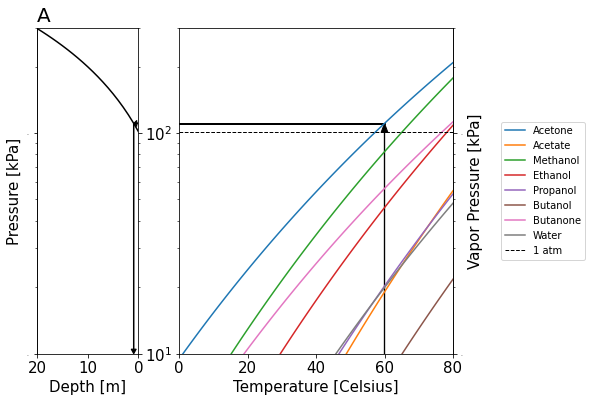

In [5]:
#Output results for publication
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6), gridspec_kw={'width_ratios': [1, 3]})
ax1.axis([20, 0, 0.1, 400])
ax2.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 10000/1000, 300000/1000])
plt.subplots_adjust(wspace=0.20)
ax1.yaxis.tick_right()

plt.rcParams['axes.spines.top'] = False

ax1.set_title("A", fontdict = {'fontsize': 20}, loc = "left")
#ax1.set_title("Pressure by depth [Pa]")
ax1.plot(h,p_height(h)/1000, color = 'black')
ax1.set_xlabel('Depth [m]', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.yaxis.tick_right()
ax_l = ax1.secondary_yaxis('left')
ax_l.tick_params(axis='y', which='major', labelsize=0)
ax_l.set_ylabel('Pressure [kPa]', fontsize=15)

#ax2.set_title("Vapor pressure of pure VOCs by Temperature [Pa]")
ax2.plot(Kelvin_Celsius(T), Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["Actt"], TR_PP, DH_vapR["Actt"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["MetOH"], TR_PP, DH_vapR["MetOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["EtOH"], TR_PP, DH_vapR["EtOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["PropOH"], TR_PP, DH_vapR["PropOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["ButOH"], TR_PP, DH_vapR["ButOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["Butnon"], TR_PP, DH_vapR["Butnon"], T, 1)/1000)
#ax2.plot(Kelvin_Celsius(T), Pt(PR["Butyrt"], T0_PP, DH_vapR["Butyrt"], T, 1)/1000) #stays below 10000 Pa
#ax2.plot(Kelvin_Celsius(T), Pt(PR["Butdiol"], T0_PP, DH_vapR["Butdiol"], T, 1)/1000) #stays below 10000 Pa
ax2.plot(Kelvin_Celsius(T), Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1)/1000)
ax2.axhline(y = 101325/1000, color = 'black', linestyle = '--', linewidth = 1)
ax2.set_xlabel('Temperature [Celsius]', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax_r = ax2.secondary_yaxis('right')#, fontsize=0)
ax_r.tick_params(axis='y', which='major', labelsize=0)
ax_r.set_ylabel('Vapor Pressure [kPa]', fontsize=15)


plt.yscale("log")

# Add arrows to demonstrate how the graph is read:
T_demo_C = 60
T_demo = Celsius_Kelvin(T_demo_C)
Inter_Demo_VP = Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], T_demo, 1)/1000
ax2.arrow(x=T_demo_C, y=0, dx=0, dy=Inter_Demo_VP, length_includes_head=True, head_width=2, head_length=10, width=0.1, facecolor='black', edgecolor='black')
ax2.arrow(x=T_demo_C, y=Inter_Demo_VP, dx=-T_demo_C, dy=0, head_width=0, head_length=0, width=1.2, facecolor='black', edgecolor='black')#, width=.08, facecolor='black', edgecolor='black')
Inter_Demo_D = (Inter_Demo_VP - P0/1000)/9.810
ax1.arrow(x=0, y=Inter_Demo_VP, dx=Inter_Demo_D, dy=0, length_includes_head=True, head_width=7, head_length=0.6, width=1.200, facecolor='black', edgecolor='black')#, width=.08, facecolor='black', edgecolor='black')
ax1.arrow(x=Inter_Demo_D, y=Inter_Demo_VP, dx=0, dy=(10000/1000-Inter_Demo_VP), length_includes_head=True, head_width=1, head_length=.500, width=0.1, facecolor='black', edgecolor='black')#, width=.08, facecolor='black', edgecolor='black')

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis, commented away due to presence in other plot
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(["Acetone","Acetate","Methanol","Ethanol","Propanol","Butanol","Butanone","Water","1 atm"],loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.show()

## Concentration effect

<p> Raoult's law </p>
<div style="text-align: center">  $ P_i = P^*_i * x_i $ [$Pa$]
    <span style="float:right;">(eq. 17)</span>
</div>

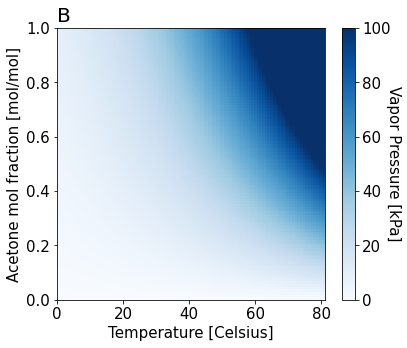

In [17]:
# generate two 2D grids for the x & y bounds
t, x = np.meshgrid(np.linspace(T0, T0+dt+1, 100), np.linspace(0, 1, 100))

#Calculate the constant C, the intersection with the y-axis
C = np.log(PR["Actn"]) + DH_vapR["Actn"]/(R*TR_PP)

z = np.exp(-DH_vapR["Actn"]/(R*t) + C) * x

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]/1000
z_min, z_max = 0, 100000/1000 #-np.abs(z).max(), np.abs(z).max()

#fig = plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(6,5))
plt.rcParams['axes.spines.top'] = True

c = ax.pcolormesh(Kelvin_Celsius(t), x, z, cmap='Blues', vmin=z_min, vmax=z_max)
plt.title("B", fontdict = {'fontsize': 20}, loc = "left")
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.ylabel('Acetone mol fraction [mol/mol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax.axis([Kelvin_Celsius(t.min()), Kelvin_Celsius(t.max()),x.min(), x.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
cbar.set_label("Vapor Pressure [kPa]", fontdict = {'fontsize': 15}, rotation=270, labelpad=10)

plt.show()

At a biologically reasonable concentration of product, what is the ratio of VOC to water in the off-gas?

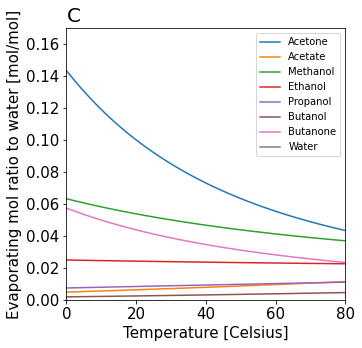

at 30c: 8.5 %
at 60c: 5.5 %


In [23]:
x = 0.01

plt.figure(figsize=(5,5))
#plt.title(f"Mol fraction of VOC in the gas, for {round(x*100)}% or {round(x*c_H2O/1000,1)}M in broth")
plt.title("C", fontdict = {'fontsize': 20}, loc = "left")
plt.plot(Kelvin_Celsius(T), Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["Actt"], TR_PP, DH_vapR["Actt"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["MetOH"], TR_PP, DH_vapR["MetOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["EtOH"], TR_PP, DH_vapR["EtOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["PropOH"], TR_PP, DH_vapR["PropOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["ButOH"], TR_PP, DH_vapR["ButOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["Butnon"], TR_PP, DH_vapR["Butnon"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
#plt.plot(Kelvin_Celsius(T), Pt(PR["Butyrt"], TR_PP, DH_vap_Butyrt, T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["vap_H2O"], T, 1))
#plt.plot(Kelvin_Celsius(T), Pt(PR["Butdiol"], TR_PP, DH_vap_Butdiol, T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["vap_H2O"], T, 1))
plt.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 0, 0.17])
plt.legend(["Acetone","Acetate","Methanol","Ethanol","Propanol","Butanol","Butanone","Water"])#,"Butyrate","Butanediol"])
plt.xlabel('Temperature [Celsius]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Evaporating mol ratio to water [mol/mol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

print("at 30c:",round(Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], Celsius_Kelvin(30), x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], Celsius_Kelvin(30), 1)*100,1),"%")
print("at 60c:",round(Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], Celsius_Kelvin(60), x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], Celsius_Kelvin(60), 1)*100,1),"%")